# ERA5 Reanalysis Products 

### 1. [Hosted by GCP](https://console.cloud.google.com/marketplace/product/bigquery-public-data/arco-era5?project=vocal-tracer-360722)

Google Cloud provides an analysis-ready, cloud optimized version of the ECMWF ERA5 reanalysis dataset. These are stored across 5 separate Zarr buckets, with additional details [here](https://console.cloud.google.com/marketplace/product/bigquery-public-data/arco-era5?project=vocal-tracer-360722). [This GitHub repository](https://github.com/google-research/arco-era5) also contains sample code and methodological details on use and production of this data.

As is described: 

> So far, we have ingested meteorologically valuable variables for the land and atmosphere. From this, we have produced a cloud-optimized version of ERA5, in which we have converted grib data to Zarr with no other modifications. In addition, we have created "analysis-ready" versions on regular lat-lon grids, oriented towards common research & ML workflows.

> This two-pronged approach for the data serves different user needs. Some researchers need full control over the interpolation of data for their analysis. Most will want a batteries-included dataset, where standard pre-processing and chunk optimization is already applied. In general, we ensure that every step in this pipeline is open and reproducible, to provide transparency in the provenance of all data.

In [27]:
import xarray as xr

ds_reanalysis = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr",
    chunks={'time': 48}, 
    consolidated=True,
)

ds_reanalysis

<xarray.Dataset> Size: 31TB
Dimensions:              (time: 374016, values: 542080)
Coordinates:
    depthBelowLandLayer  float64 8B ...
    entireAtmosphere     float64 8B ...
    latitude             (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude            (values) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    number               int64 8B ...
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
  * time                 (time) datetime64[ns] 3MB 1979-01-01 ... 2021-08-31T...
    valid_time           (time) datetime64[ns] 3MB dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    d2m                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    hcc                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl1                (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl2                (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl3                (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    ...                   ...
    tsn                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u10                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u100                 (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v10                  (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v100                 (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
    z                    (time, values) float32 811GB dask.array<chunksize=(48, 542080), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    GRIB_centre:               ecmf
    GRIB_centreDescription:    European Centre for Medium-Range Weather Forec...
    GRIB_edition:              1
    GRIB_subCentre:            0
    history:                   2022-09-23T18:56 GRIB to CDM+CF via cfgrib-0.9...
    institution:               European Centre for Medium-Range Weather Forec...
    pangeo-forge:inputs_hash:  5f4378143e9f42402424280b63472752da3aa79179b53b...
    pangeo-forge:recipe_hash:  0c3415923e347ce9dac9dc5c6d209525f4d45d799bd25b...
    pangeo-forge:version:      0.9.1

### 2. Hosted by [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/era5-pds#overview)

This data can be queried using the [STAC API](https://pystac-client.readthedocs.io/en/stable/)

The data assets are a collection of Zarr groups, which can be opened with libraries like xarray.

Each STAC item covers a single month and the entire globe. You'll likely query on the datetime.

There will be two items per month, depending on the kind of variables within: fc (or "forecast") and an (or "analysis").

- An analysis, of the atmospheric conditions, is a blend of observations with a previous forecast. An analysis can only provide instantaneous parameters (parameters valid at a specific time, e.g temperature at 12:00), but not accumulated parameters, mean rates or min/max parameters.

- A forecast starts with an analysis at a specific time (the 'initialization time'), and a model computes the atmospheric conditions for a number of 'forecast steps', at increasing 'validity times', into the future. A forecast can provide instantaneous parameters, accumulated parameters, mean rates, and min/max parameters.

You can narrow your search to a specific kind using the `era5:kind` property.

In [26]:
import pystac_client
import planetary_computer
import xarray as xr

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
search = catalog.search(
    collections=["era5-pds"], datetime="1980-01", query={"era5:kind": {"eq": "an"}}
)
items = search.item_collection()
item = items[0]

signed_item = planetary_computer.sign(item)
datasets = [
    xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
    for asset in signed_item.assets.values()
]

ds = xr.combine_by_coords(datasets, join="exact")
ds



<xarray.Dataset> Size: 28GB
Dimensions:                            (time: 744, lat: 721, lon: 1440)
Coordinates:
  * lat                                (lat) float32 3kB 90.0 89.75 ... -90.0
  * lon                                (lon) float32 6kB 0.0 0.25 ... 359.8
  * time                               (time) datetime64[ns] 6kB 1980-01-01 ....
Data variables:
    air_pressure_at_mean_sea_level     (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    air_temperature_at_2_metres        (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    dew_point_temperature_at_2_metres  (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    eastward_wind_at_100_metres        (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    eastward_wind_at_10_metres         (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    northward_wind_at_100_metres       (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    northward_wind_at_10_metres        (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    sea_surface_temperature            (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    surface_air_pressure               (time, lat, lon) float32 3GB dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

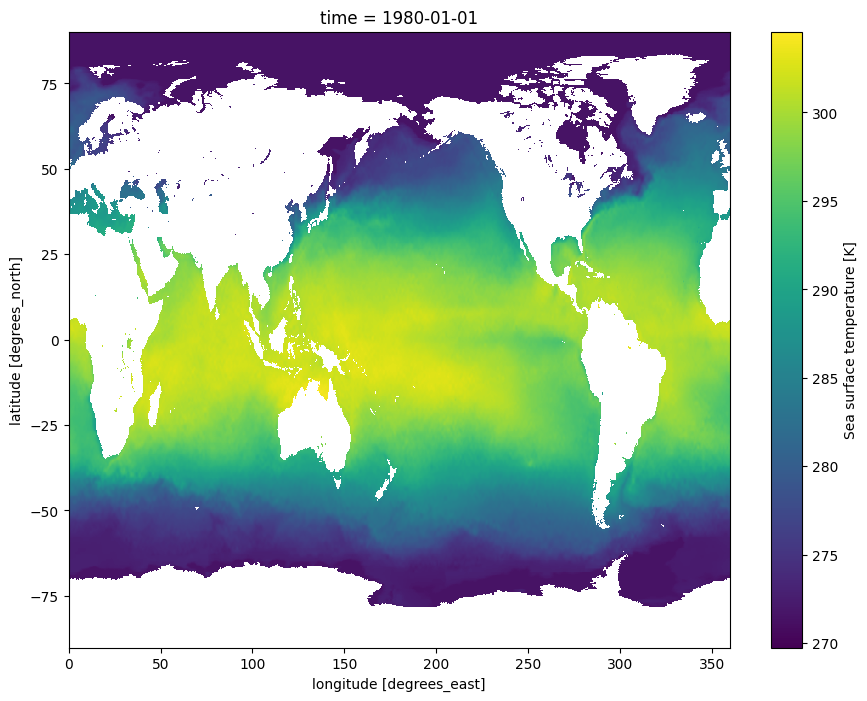

In [4]:
ds["sea_surface_temperature"].isel(time=0).plot(size=8)